In [37]:
import os
#os.chdir('../')
current_directory = os.getcwd()
print("Current Directory:", current_directory)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from support.attention_layer import AttentionLayer
from support.AttentionSupport import my_precision, my_recall, my_f1, my_roc_auc, get_specificity, get_balanced_acc, plotConfusionMatrix, plotCurves, progressBar, plotROCCurve

Current Directory: c:\Users\Darren Chong\Documents\School\Thesis B\Spectrogram-Based-Omics-Imagification


In [25]:
expr_file = r"./data/Li/data.csv"
expr = pd.read_csv(expr_file, sep=",")
y = expr.iloc[:, 0].values
X = expr.iloc[:, 1:].values
df = pd.DataFrame(y, columns=['info'])
df['value'] = df['info'].str.split(':').str[0]
y = df['value']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)
print(np.unique(df['value'], return_counts=True))

(array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrM', 'chrX', 'chrY'], dtype=object), array([5297, 2226, 3182, 2788, 1200, 2233, 2067, 2311, 2884, 1114, 2895,
       4004, 1302,  730, 1257, 3072, 2539, 2833, 2879, 2852, 2356, 2303,
         13, 2370,  534], dtype=int64))


In [39]:
def scaler_fit(X: np.ndarray) -> tuple:
    """Compute parameters needed for log normalization and scaling."""
    min0 = X.min(axis=0)
    max_val = np.log(X + np.abs(min0) + 1).max()
    return min0, max_val

def scaler_transform(X: np.ndarray, min0: np.ndarray, max_val: float) -> np.ndarray:
    """Apply log normalization and scaling to the input data."""
    X_norm = np.log(X + np.abs(min0) + 1).clip(0, None)
    return (X_norm / max_val).clip(0, 1)

def scaler_fit_transform(X: np.ndarray) -> np.ndarray:
    """Combine fitting and transforming steps."""
    min0, max_val = scaler_fit(X)
    return (scaler_transform(X, min0, max_val), min0, max_val)

(X_train_norm, min0, max_val) = scaler_fit_transform(X_train)
X_test_norm = scaler_transform(X_test, min0, max_val)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = np.unique(y_train_enc).size
ohe = OneHotEncoder(sparse=False)
y_train_ohe = ohe.fit_transform(y_train_enc.reshape(-1, 1))
y_test_ohe = ohe.transform(y_test_enc.reshape(-1, 1))

c:\Programs\Anaconda3\envs\py310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=1,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)
X_embedded = reducer.fit_transform(X_train_norm.T)

indexed_list = list(enumerate(X_embedded))
# Sort the indexed list by value
sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1])
sorted_indices = [index for index, _ in sorted_indexed_list]

In [19]:
sampling_rate = 1000  # Hz
window_length = 16
overlap = 16

def compute_log_mel_spectrogram(y, sr):
    n_fft = 64
    hop_length = 16
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(D)
    n_mels = 32
    mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Function to standardize spectrogram
def standardize_spectrogram(log_mel_spectrogram, global_mean, global_std):
    scaler = StandardScaler()
    scaler.mean_ = global_mean
    scaler.scale_ = global_std
    standardized_spectrogram = scaler.transform(log_mel_spectrogram.T).T  # Transpose for correct standardization
    return standardized_spectrogram

concatenated = np.concatenate([compute_log_mel_spectrogram(X_train_norm[i], sampling_rate).T for i in range(X_train_norm.shape[0])], axis=0)
global_mean = np.mean(concatenated, axis=0)
global_std = np.std(concatenated, axis=0)
np.save('./Li/global_mean.npy', global_mean)
np.save('./Li/global_std.npy', global_std)

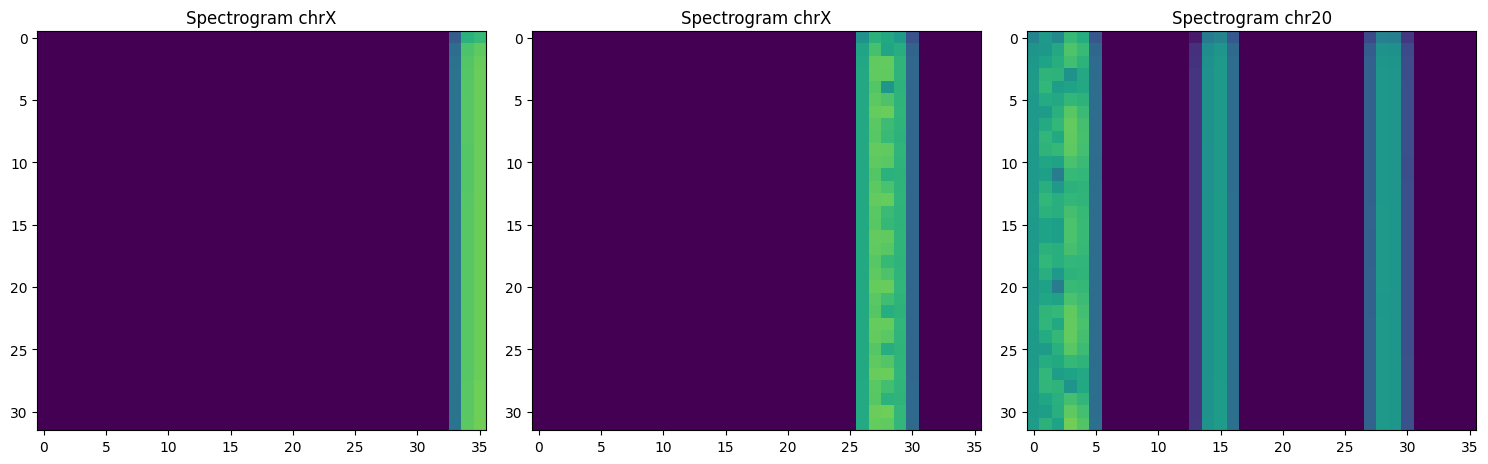

In [20]:
# Initialize an empty list to store the wavelet spectrograms
wavelet_spectrograms_train = []

for i in range(X_train_norm.shape[0]):
    sorted_train = np.array([X_train_norm[i][m] for m in sorted_indices])
    log_mel_spectrogram = compute_log_mel_spectrogram(sorted_train, sampling_rate)
    standardized_spectrogram = standardize_spectrogram(log_mel_spectrogram, global_mean, global_std)
    
    # Convert standardized spectrogram to RGB image using viridis color map
    rgb_image = plt.cm.viridis(standardized_spectrogram)[:, :, :3]

    # Append to the list of wavelet spectrograms
    wavelet_spectrograms_train.append(rgb_image)

# Convert the list to a NumPy array
wavelet_spectrograms_train = np.array(wavelet_spectrograms_train)
# Plot the wavelet spectrograms
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(wavelet_spectrograms_train[i])
    ax[i].title.set_text('Spectrogram {}'.format(y_train[i]))

plt.tight_layout()

# Initialize an empty list to store the wavelet spectrograms
wavelet_spectrograms_test = []

# Apply wavelet transform for each row in the data
for i in range(X_test_norm.shape[0]):
    sorted_test = np.array([X_test_norm[i][m] for m in sorted_indices])
    log_mel_spectrogram = compute_log_mel_spectrogram(sorted_test, sampling_rate)
    standardized_spectrogram = standardize_spectrogram(log_mel_spectrogram, global_mean, global_std)
    
    # Convert standardized spectrogram to RGB image using viridis color map
    rgb_image = plt.cm.viridis(standardized_spectrogram)[:, :, :3]

    wavelet_spectrograms_test.append(rgb_image)
# Convert the list to a NumPy array
wavelet_spectrograms_test = np.array(wavelet_spectrograms_test)

In [40]:
num_folds = 10
fold_no = 1

acc_per_fold = []
recall_per_fold = []
precision_per_fold = []
roc_auc_per_fold = []
f1_per_fold = []
balanced_acc = []
specificity_per_fold = []
loss_per_fold = []
histories = []

input_shape = (32, 36,3)

METRICS = [
    tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
    tensorflow.keras.metrics.Precision(name='precision'),
    tensorflow.keras.metrics.Recall(name='recall'),
    tensorflow.keras.metrics.AUC(name='AUC')
]

kfold = KFold(n_splits=num_folds, shuffle=True,random_state=75)

for train,test in kfold.split(wavelet_spectrograms_train, y_train_ohe):
    epochs = 500
    batch_size = 256
    learning_rate = 0.001
    optimizer = tensorflow.keras.optimizers.Adamax(learning_rate = learning_rate)
    filepath="./Li/weights/model_best_weights_"+str(fold_no)+".hdf5"    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    ###### Model architecture
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    inputs = Input(shape=input_shape,name='input')
    x = Conv2D(16,(2,2),strides=(1,1),padding='valid',kernel_initializer='normal')(inputs)
    x = AveragePooling2D((2,2), strides=(1,1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(32,(2,2), strides=(1, 1), padding="valid",kernel_initializer='normal')(x)
    x = AveragePooling2D((2,2), strides=(1,1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64,(2,2), strides=(1, 1), padding="valid",kernel_initializer='normal')(x)
    x = AveragePooling2D((2,2), strides=(1,1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128,(2,2), strides=(1, 1), padding="valid",kernel_initializer='normal')(x)
    x = AveragePooling2D((2,2), strides=(1,1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    td = Reshape([24,28*128])(x)
    x = LSTM(256, return_sequences=True)(td)
    x = Activation('tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = AttentionLayer(return_sequences=False)(x)
    x = Dense(100)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, name='output_layer')(x)
    x = Activation('softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=METRICS)
  
    history = model.fit(wavelet_spectrograms_train[train], y_train_ohe[train], batch_size=batch_size, epochs=epochs, validation_data=(wavelet_spectrograms_train[test], y_train_ohe[test]), verbose=2, callbacks=[checkpoint])
    histories.append(history)
    scores = model.evaluate(wavelet_spectrograms_train[test], y_train_enc[test], verbose=0)
    covPredict = model.predict(wavelet_spectrograms_train[test])
    covPredict = np.where(covPredict >= 0.5, 1,0)
    real_stat = y_train_enc[test]
    acc_per_fold.append(scores[1])
    recall_per_fold.append(my_recall(real_stat, covPredict))
    precision_per_fold.append(my_precision(real_stat, covPredict))
    roc_auc_per_fold.append(my_roc_auc(real_stat, covPredict))
    f1_per_fold.append(my_f1(real_stat, covPredict))
    balanced_acc.append(get_balanced_acc(real_stat, covPredict))
    specificity_per_fold.append((2*get_balanced_acc(y_train_enc[test],covPredict))-my_recall(y_train_enc[test],covPredict))
    loss_per_fold.append(scores[0])
    model = load_model('./Li/weights/model_best_weights_'+str(fold_no)+'.hdf5')
    score = model.evaluate(wavelet_spectrograms_train[test],y_train_enc[test], verbose=0)
    covPredict = model.predict(wavelet_spectrograms_train[test])
    covPredict = np.where(covPredict > 0.5, 1,0)
    print("Validation results for the fold "+str(fold_no)+":")
    print("Accuracy : ",score[1])
    print("Precision : ",my_precision(y_train_enc[test],covPredict))
    print("Recall : ",my_recall(y_train_enc[test],covPredict))
    print("F1 : ",my_f1(y_train_enc[test],covPredict))
    print("ROC AUC : ",my_roc_auc(y_train_enc[test],covPredict))
    print("Specificity : ",(2*get_balanced_acc(y_train_enc[test],covPredict))-my_recall(y_train_enc[test],covPredict))
    score = model.evaluate(wavelet_spectrograms_test,y_test_enc,verbose=0)
    covPredict = model.predict(wavelet_spectrograms_test)
    covPredict = np.where(covPredict >= 0.5, 1,0)
    print("Test results for the fold "+str(fold_no)+":")
    print("Accuracy : ",score[1])
    print("Precision : ",my_precision(y_test_enc,covPredict))
    print("Recall : ",my_recall(y_test_enc,covPredict))
    print("F1 : ",my_f1(y_test_enc,covPredict))
    print("ROC AUC : ",my_roc_auc(y_test_enc,covPredict))
    print("Specificity : ",(2*get_balanced_acc(y_test_enc,covPredict))-my_recall(y_test_enc,covPredict))
    fold_no = fold_no + 1

print("Accuracy per fold : ",acc_per_fold)
print("Precision per fold : ",precision_per_fold)
print("Recall per fold : ",recall_per_fold)
print("ROC AUC per fold : ",roc_auc_per_fold)
print("F1 per fold : ",f1_per_fold)
print("Specificity per fold : ",specificity_per_fold)

print("Mean Accuracy : ",np.mean(acc_per_fold))
print("std Accuracy : ",np.std(acc_per_fold))
print("Mean Precision : ",np.mean(precision_per_fold))
print("std Precision : ",np.std(precision_per_fold))
print("Mean Recall : ",np.mean(recall_per_fold))
print("std Recall : ",np.std(recall_per_fold))
print("Mean ROC AUC : ",np.mean(roc_auc_per_fold))
print("std ROC AUC : ",np.std(roc_auc_per_fold))
print("Mean F1 : ",np.mean(f1_per_fold))
print("std F1 : ",np.std(f1_per_fold))
print("Mean Specificity : ",np.mean(get_specificity(balanced_acc,recall_per_fold)))
print("std Specificity : ",np.std(get_specificity(balanced_acc,recall_per_fold)))

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/500


Epoch 1: val_accuracy improved from -inf to 0.96000, saving model to ./Li/weights\model_best_weights_1.hdf5
161/161 - 93s - loss: 3.2383 - accuracy: 0.9599 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5727 - val_loss: 3.1593 - val_accuracy: 0.9600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.6010 - 93s/epoch - 576ms/step
Epoch 2/500


c:\Programs\Anaconda3\envs\py310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.96000
161/161 - 89s - loss: 3.1429 - accuracy: 0.9600 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6084 - val_loss: 3.1233 - val_accuracy: 0.9600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.6216 - 89s/epoch - 554ms/step
Epoch 3/500

Epoch 3: val_accuracy did not improve from 0.96000
161/161 - 88s - loss: 3.1262 - accuracy: 0.9600 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6180 - val_loss: 3.1125 - val_accuracy: 0.9600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.6230 - 88s/epoch - 544ms/step
Epoch 4/500

Epoch 4: val_accuracy did not improve from 0.96000
161/161 - 89s - loss: 3.1170 - accuracy: 0.9600 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6228 - val_loss: 3.1049 - val_accuracy: 0.9600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.6260 - 89s/epoch - 550ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.96000
161/161 - 89s - loss:

KeyboardInterrupt: 

In [ ]:
### Use the index of the best obtained model according to the test results

best_model = 7

model = load_model('model_best_weights_'+str(best_model)+'.hdf5')
score = model.evaluate(wavelet_spectrograms_test,y_test_enc, verbose=0)
covPredict = model.predict(wavelet_spectrograms_test)
covPredict = np.where(covPredict >= 0.5, 1,0)

## Plot confusion matrix
    
plotConfusionMatrix(y_test_enc,covPredict)

## Plot accuracy curves
plotCurves('Attention-based CNN-LSTM train and validation accuracy curves','Accuracy','Epoch','accuracy',histories)

## Plot loss curves
plotCurves('Attention-based CNN-LSTM train and validation loss curves','Loss','Epoch','loss',histories)

## Plot Sensitivity curves
plotCurves('Attention-based CNN-LSTM train and validation sensitivity curves','Sensitivity','Epoch','recall',histories)

## Plot Precision curves
plotCurves('Attention-based CNN-LSTM train and validation precision curves','Precision','Epoch','precision',histories)

## Plot ROC curve

probabilities = model.predict(wavelet_spectrograms_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test_enc, probabilities, pos_label=1)
auc = auc(fpr, tpr)
plotROCCurve(fpr,tpr,auc,'darkred','Attention-based CNN-LSTM ROC AUC ','Attention-based CNN-LSTM baseline ROC AUC')